## Tutorial 1 - Turbofan Aircraft Simulation
Welcome to this tutorial on simulating a turbofan aircraft using RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs.

---

## 1. Header and Imports


The **Imports** section is divided into two parts: general-purpose Python libraries and simulation-specific libraries.

In [1]:
# python imports 
import numpy as np  
from copy import deepcopy
import matplotlib.pyplot as plt  
import os
from pathlib import Path

## 2. RCAIDE Imports

The **RCAIDE Imports** section includes the core modules needed for the simulation. These libraries provide specialized classes and tools for building, analyzing, and running aircraft models.

### Key Imports:

1. **RCAIDE**: The core package is imported directly. This approach allows us to access specific classes and methods from RCAIDE without repeatedly importing individual components at the top of the script.

2. **`Units` Module**: The Units module is a standardized way to handle unit conversions within RCAIDE. It ensures consistent units across all inputs and outputs, reducing the likelihood of conversion errors.

In [2]:
# RCAIDE imports 
import RCAIDE
from RCAIDE.Framework.Core import Units   
from RCAIDE.Library.Methods.Propulsors.Turbofan_Propulsor          import design_turbofan 
from RCAIDE.Library.Methods.Weights.Moment_of_Inertia.compute_aircraft_moment_of_inertia import compute_aircraft_moment_of_inertia
from RCAIDE.Library.Methods.Weights.Center_of_Gravity              import compute_vehicle_center_of_gravity
from RCAIDE.Library.Methods.Geometry.Planform                      import segment_properties
from RCAIDE.Library.Plots                                          import *     

# Vehicle Setup

The **`vehicle_setup`** function defines the baseline configuration of the aircraft. This section builds the vehicle step-by-step by specifying its components, geometric properties, and high-level parameters.

---

## 1. Creating the Vehicle Instance

The setup begins by creating a vehicle instance and assigning it a **tag**. The tag is a unique string identifier used to reference the vehicle during analysis or in post-processing steps.

---

## 2. Defining High-Level Vehicle Parameters

The high-level parameters describe the aircraft’s key operational characteristics, such as:

- **Maximum Takeoff Weight**: The heaviest allowable weight of the aircraft for safe flight.
- **Operating Empty Weight**: The aircraft weight without fuel, passengers, or payload.
- **Payload**: The weight of cargo and passengers.
- **Max Zero Fuel Weight**: The maximum weight of the aircraft excluding fuel.

Units for these parameters can be converted automatically using the `Units` module to ensure consistency and reduce errors.

---

## 3. Defining the Landing Gear

Landing gear parameters, such as the number of main and nose wheels, are set for the aircraft. While not used in this tutorial, these values can be applied in advanced analyses, such as **ground loads** or **noise prediction**.

---

## 4. Main Wing Setup

The main wing is added using the **`Main_Wing`** class. This designation ensures that the primary lifting surface is recognized correctly by the analysis tools. Key properties of the wing include:

- **Area**: The total wing surface area.
- **Span**: The length of the wing from tip to tip.
- **Aspect Ratio**: A ratio of span to average chord, determining wing efficiency.
- **Segments**: Divisions of the wing geometry (e.g., root and tip sections).
- **Control Surfaces**: High-lift devices like flaps and ailerons, defined by span fractions and deflections.

---

## 5. Horizontal and Vertical Stabilizers

The stabilizers provide stability and control for the aircraft:

- **Horizontal Stabilizer**: Defined using the `Horizontal_Tail` class. It follows a similar setup to the main wing but acts as a stabilizing surface.
- **Vertical Stabilizer**: Defined using the `Vertical_Tail` class, with an additional option to designate the tail as a **T-tail** for weight calculations.

---

## 6. Fuselage Definition

The fuselage is modeled by specifying its geometric parameters, such as:

- **Length**: The overall length of the aircraft body.
- **Width**: The widest part of the fuselage cross-section.
- **Height**: The height of the fuselage.

These values influence drag calculations and overall structural weight.

---

## 7. Energy Network: Turbofan Engine

The **energy network** models the propulsion system, in this case, a turbofan engine. The turbofan network determines the engine’s thrust, bypass ratio, and fuel type. These parameters are essential for performance and fuel efficiency analyses.

More detailed information about turbofan behavior and configurations is provided in the **Turbofan Modeling Tutorial**.

---

In [3]:
def vehicle_setup(): 
    
    # ------------------------------------------------------------------
    #   Initialize the Vehicle
    # ------------------------------------------------------------------    
    
    vehicle = RCAIDE.Vehicle()
    vehicle.tag = 'Boeing_737-800'
    # ################################################# Vehicle-level Properties #################################################   
    vehicle.mass_properties.max_takeoff               = 79015.8 * Units.kilogram  
    vehicle.mass_properties.takeoff                   = 79015.8 * Units.kilogram    
    vehicle.mass_properties.operating_empty           = 62746.4 * Units.kilogram  
    vehicle.mass_properties.max_zero_fuel             = 62732.0 * Units.kilogram 
    vehicle.mass_properties.cargo                     = 10000.  * Units.kilogram  
    vehicle.mass_properties.center_of_gravity         = [[21,0, 0, 0]]
    vehicle.flight_envelope.ultimate_load             = 3.75
    vehicle.flight_envelope.positive_limit_load       = 2.5 
    vehicle.flight_envelope.design_mach_number        = 0.78 
    vehicle.flight_envelope.design_cruise_altitude    = 35000*Units.feet
    vehicle.flight_envelope.design_range              = 3500 * Units.nmi
    vehicle.reference_area                            = 124.862 * Units['meters**2']   
    vehicle.passengers                                = 170
    vehicle.systems.control                           = "fully powered" 
    vehicle.systems.accessories                       = "medium range"
    
     # ################################################# Landing Gear #############################################################   
    # ------------------------------------------------------------------        
    #  Landing Gear
    # ------------------------------------------------------------------  
    main_gear               = RCAIDE.Library.Components.Landing_Gear.Main_Landing_Gear()
    main_gear.tire_diameter = 1.12000 * Units.m
    main_gear.strut_length  = 1.8 * Units.m 
    main_gear.units         = 2    # Number of main landing gear
    main_gear.wheels        = 2    # Number of wheels on the main landing gear
    vehicle.append_component(main_gear)  

    nose_gear               = RCAIDE.Library.Components.Landing_Gear.Nose_Landing_Gear()       
    nose_gear.tire_diameter = 0.6858 * Units.m
    nose_gear.units         = 1    # Number of nose landing gear
    nose_gear.wheels        = 2    # Number of wheels on the nose landing gear
    nose_gear.strut_length  = 1.3 * Units.m 
    vehicle.append_component(nose_gear)
    # ################################################# Wings ##################################################################### 
    # ------------------------------------------------------------------
    #   Main Wing
    # ------------------------------------------------------------------
 
    wing                                  = RCAIDE.Library.Components.Wings.Main_Wing()
    wing.tag                              = 'main_wing' 
    wing.aspect_ratio                     = 10.18
    wing.sweeps.quarter_chord             = 25 * Units.deg
    wing.thickness_to_chord               = 0.1
    wing.taper                            = 0.1 
    wing.spans.projected                  = 34.32 
    wing.chords.root                      = 7.760 * Units.meter
    wing.chords.tip                       = 0.782 * Units.meter
    wing.chords.mean_aerodynamic          = 4.235 * Units.meter 
    wing.areas.reference                  = 124.862
    wing.areas.wetted                     = 225.08 
    wing.twists.root                      = 4.0 * Units.degrees
    wing.twists.tip                       = 0.0 * Units.degrees 
    wing.origin                           = [[13.61,0,-0.5]]
    wing.aerodynamic_center               = [0,0,0] 
    wing.vertical                         = False
    wing.symmetric                        = True
    wing.high_lift                        = True 
    wing.dynamic_pressure_ratio           = 1.0
    # Wing Segments
    root_airfoil                          = RCAIDE.Library.Components.Airfoils.Airfoil()
    ospath                                = os.path.abspath(os.path.join('Notebook'))
    separator                             = os.path.sep
    rel_path = os.path.dirname(ospath) + separator + '..' + separator + '..' + separator + 'Regressions' + separator + 'Vehicles' + separator
    root_airfoil.coordinate_file          = rel_path  + 'Airfoils' + separator + 'B737a.txt'
    segment                               = RCAIDE.Library.Components.Wings.Segment()
    segment.tag                           = 'Root'
    segment.percent_span_location         = 0.0
    segment.twist                         = 4. * Units.deg
    segment.root_chord_percent            = 1.
    segment.thickness_to_chord            = 0.1
    segment.dihedral_outboard             = 2.5 * Units.degrees
    segment.sweeps.quarter_chord          = 28.225 * Units.degrees
    segment.thickness_to_chord            = .1
    segment.append_airfoil(root_airfoil)
    wing.append_segment(segment)

    yehudi_airfoil                        = RCAIDE.Library.Components.Airfoils.Airfoil()
    yehudi_airfoil.coordinate_file        = rel_path+ 'Airfoils' + separator + 'B737b.txt'
    segment                               = RCAIDE.Library.Components.Wings.Segment()
    segment.tag                           = 'Yehudi'
    segment.percent_span_location         = 0.324
    segment.twist                         = 0.047193 * Units.deg
    segment.root_chord_percent            = 0.5
    segment.thickness_to_chord            = 0.1
    segment.dihedral_outboard             = 5.5 * Units.degrees
    segment.sweeps.quarter_chord          = 25. * Units.degrees
    segment.thickness_to_chord            = .1
    segment.append_airfoil(yehudi_airfoil)
    wing.append_segment(segment)

    mid_airfoil                           = RCAIDE.Library.Components.Airfoils.Airfoil()
    mid_airfoil.coordinate_file           = rel_path + 'Airfoils' + separator + 'B737c.txt'
    segment                               = RCAIDE.Library.Components.Wings.Segment()
    segment.tag                           = 'Section_2'
    segment.percent_span_location         = 0.963
    segment.twist                         = 0.00258 * Units.deg
    segment.root_chord_percent            = 0.220
    segment.thickness_to_chord            = 0.1
    segment.dihedral_outboard             = 5.5 * Units.degrees
    segment.sweeps.quarter_chord          = 56.75 * Units.degrees
    segment.thickness_to_chord            = .1
    segment.append_airfoil(mid_airfoil)
    wing.append_segment(segment)

    tip_airfoil                           =  RCAIDE.Library.Components.Airfoils.Airfoil()
    tip_airfoil.coordinate_file           = rel_path + 'Airfoils' + separator + 'B737d.txt'
    segment                               = RCAIDE.Library.Components.Wings.Segment()
    segment.tag                           = 'Tip'
    segment.percent_span_location         = 1.
    segment.twist                         = 0. * Units.degrees
    segment.root_chord_percent            = 0.10077
    segment.thickness_to_chord            = 0.1
    segment.dihedral_outboard             = 0.
    segment.sweeps.quarter_chord          = 0.
    segment.thickness_to_chord            = .1
    segment.append_airfoil(tip_airfoil)
    wing.append_segment(segment)
    
    # Fill out more segment properties automatically
    wing = segment_properties(wing)    
    # control surfaces -------------------------------------------
    slat                          = RCAIDE.Library.Components.Wings.Control_Surfaces.Slat()
    slat.tag                      = 'slat'
    slat.span_fraction_start      = 0.2
    slat.span_fraction_end        = 0.963
    slat.deflection               = 0.0 * Units.degrees
    slat.chord_fraction           = 0.075
    wing.append_control_surface(slat)

    flap                          = RCAIDE.Library.Components.Wings.Control_Surfaces.Flap()
    flap.tag                      = 'flap'
    flap.span_fraction_start      = 0.2
    flap.span_fraction_end        = 0.7
    flap.deflection               = 0.0 * Units.degrees
    flap.configuration_type       = 'double_slotted'
    flap.chord_fraction           = 0.30
    wing.append_control_surface(flap)

    aileron                       = RCAIDE.Library.Components.Wings.Control_Surfaces.Aileron()
    aileron.tag                   = 'aileron'
    aileron.span_fraction_start   = 0.7
    aileron.span_fraction_end     = 0.963
    aileron.deflection            = 0.0 * Units.degrees
    aileron.chord_fraction        = 0.16
    wing.append_control_surface(aileron)

    # add to vehicle
    vehicle.append_component(wing)
     # ------------------------------------------------------------------
    #  Horizontal Stabilizer
    # ------------------------------------------------------------------

    wing     = RCAIDE.Library.Components.Wings.Horizontal_Tail()
    wing.tag = 'horizontal_stabilizer'

    wing.aspect_ratio            = 4.99
    wing.sweeps.quarter_chord    = 28.2250 * Units.deg  
    wing.thickness_to_chord      = 0.08
    wing.taper                   = 0.3333  
    wing.spans.projected         = 14.4 
    wing.chords.root             = 4.2731 
    wing.chords.tip              = 1.4243 
    wing.chords.mean_aerodynamic = 8.0 
    wing.areas.reference         = 41.49
    wing.areas.exposed           = 59.354    # Exposed area of the horizontal tail
    wing.areas.wetted            = 71.81     # Wetted area of the horizontal tail
    wing.twists.root             = 3.0 * Units.degrees
    wing.twists.tip              = 3.0 * Units.degrees 
    wing.origin                  = [[33.02,0,1.466]]
    wing.aerodynamic_center      = [0,0,0] 
    wing.vertical                = False
    wing.symmetric               = True 
    wing.dynamic_pressure_ratio  = 0.9


    # Wing Segments
    segment                        = RCAIDE.Library.Components.Wings.Segment()
    segment.tag                    = 'root_segment'
    segment.percent_span_location  = 0.0
    segment.twist                  = 0. * Units.deg
    segment.root_chord_percent     = 1.0
    segment.dihedral_outboard      = 8.63 * Units.degrees
    segment.sweeps.quarter_chord   = 28.2250  * Units.degrees 
    segment.thickness_to_chord     = .1
    wing.append_segment(segment)

    segment                        = RCAIDE.Library.Components.Wings.Segment()
    segment.tag                    = 'tip_segment'
    segment.percent_span_location  = 1.
    segment.twist                  = 0. * Units.deg
    segment.root_chord_percent     = 0.3333               
    segment.dihedral_outboard      = 0 * Units.degrees
    segment.sweeps.quarter_chord   = 0 * Units.degrees  
    segment.thickness_to_chord     = .1
    wing.append_segment(segment)
    
    # Fill out more segment properties automatically
    wing = segment_properties(wing)        

    # control surfaces -------------------------------------------
    elevator                       = RCAIDE.Library.Components.Wings.Control_Surfaces.Elevator()
    elevator.tag                   = 'elevator'
    elevator.span_fraction_start   = 0.09
    elevator.span_fraction_end     = 0.92
    elevator.deflection            = 0.0  * Units.deg
    elevator.chord_fraction        = 0.3
    wing.append_control_surface(elevator)

    # add to vehicle
    vehicle.append_component(wing)

    # ------------------------------------------------------------------
    #   Vertical Stabilizer
    # ------------------------------------------------------------------

    wing = RCAIDE.Library.Components.Wings.Vertical_Tail()
    wing.tag = 'vertical_stabilizer'

    wing.aspect_ratio            = 1.98865
    wing.sweeps.quarter_chord    = 31.2  * Units.deg   
    wing.thickness_to_chord      = 0.08
    wing.taper                   = 0.1183

    wing.spans.projected         = 8.33
    wing.total_length            = wing.spans.projected 
    
    wing.chords.root             = 10.1 
    wing.chords.tip              = 1.20 
    wing.chords.mean_aerodynamic = 4.0

    wing.areas.reference         = 34.89
    wing.areas.wetted            = 57.25 
    
    wing.twists.root             = 0.0 * Units.degrees
    wing.twists.tip              = 0.0 * Units.degrees

    wing.origin                  = [[26.944,0,1.54]]
    wing.aerodynamic_center      = [0,0,0]

    wing.vertical                = True
    wing.symmetric               = False
    wing.t_tail                  = False

    wing.dynamic_pressure_ratio  = 1.0


    # Wing Segments
    segment                               = RCAIDE.Library.Components.Wings.Segment()
    segment.tag                           = 'root'
    segment.percent_span_location         = 0.0
    segment.twist                         = 0. * Units.deg
    segment.root_chord_percent            = 1.
    segment.dihedral_outboard             = 0 * Units.degrees
    segment.sweeps.quarter_chord          = 61.485 * Units.degrees  
    segment.thickness_to_chord            = .1
    wing.append_segment(segment)

    segment                               = RCAIDE.Library.Components.Wings.Segment()
    segment.tag                           = 'segment_1'
    segment.percent_span_location         = 0.2962
    segment.twist                         = 0. * Units.deg
    segment.root_chord_percent            = 0.45
    segment.dihedral_outboard             = 0. * Units.degrees
    segment.sweeps.quarter_chord          = 31.2 * Units.degrees   
    segment.thickness_to_chord            = .1
    wing.append_segment(segment)

    segment                               = RCAIDE.Library.Components.Wings.Segment()
    segment.tag                           = 'segment_2'
    segment.percent_span_location         = 1.0
    segment.twist                         = 0. * Units.deg
    segment.root_chord_percent            = 0.1183 
    segment.dihedral_outboard             = 0.0 * Units.degrees
    segment.sweeps.quarter_chord          = 0.0    
    segment.thickness_to_chord            = .1  
    wing.append_segment(segment)
    
    
    # Fill out more segment properties automatically
    wing = segment_properties(wing)        

    # add to vehicle
    vehicle.append_component(wing)
     # ################################################# Fuselage ################################################################ 
    
    fuselage                                    = RCAIDE.Library.Components.Fuselages.Tube_Fuselage() 
    fuselage.number_coach_seats                 = vehicle.passengers 
    fuselage.seats_abreast                      = 6
    fuselage.seat_pitch                         = 1     * Units.meter 
    fuselage.fineness.nose                      = 1.6
    fuselage.fineness.tail                      = 2. 
    fuselage.lengths.nose                       = 6.4   * Units.meter
    fuselage.lengths.tail                       = 8.0   * Units.meter
    fuselage.lengths.total                      = 38.02 * Units.meter  
    fuselage.lengths.fore_space                 = 6.    * Units.meter
    fuselage.lengths.aft_space                  = 5.    * Units.meter
    fuselage.width                              = 3.74  * Units.meter
    fuselage.heights.maximum                    = 3.74  * Units.meter
    fuselage.effective_diameter                 = 3.74     * Units.meter
    fuselage.areas.side_projected               = 142.1948 * Units['meters**2'] 
    fuselage.areas.wetted                       = 446.718  * Units['meters**2'] 
    fuselage.areas.front_projected              = 12.57    * Units['meters**2']  
    fuselage.differential_pressure              = 5.0e4 * Units.pascal 
    fuselage.heights.at_quarter_length          = 3.74 * Units.meter
    fuselage.heights.at_three_quarters_length   = 3.65 * Units.meter
    fuselage.heights.at_wing_root_quarter_chord = 3.74 * Units.meter

    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment() 
    segment.tag                                 = 'segment_0'    
    segment.percent_x_location                  = 0.0000
    segment.percent_z_location                  = -0.00144 
    segment.height                              = 0.0100 
    segment.width                               = 0.0100  
    fuselage.Segments.append(segment)   
    
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment() 
    segment.tag                                 = 'segment_1'    
    segment.percent_x_location                  = 0.00576 
    segment.percent_z_location                  = -0.00144 
    segment.height                              = 0.7500
    segment.width                               = 0.6500
    fuselage.Segments.append(segment)   
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_2'   
    segment.percent_x_location                  = 0.02017 
    segment.percent_z_location                  = 0.00000 
    segment.height                              = 1.52783 
    segment.width                               = 1.20043 
    fuselage.Segments.append(segment)      
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_3'   
    segment.percent_x_location                  = 0.03170 
    segment.percent_z_location                  = 0.00000 
    segment.height                              = 1.96435 
    segment.width                               = 1.52783 
    fuselage.Segments.append(segment)   

    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_4'   
    segment.percent_x_location                  = 0.04899 	
    segment.percent_z_location                  = 0.00431 
    segment.height                              = 2.72826 
    segment.width                               = 1.96435 
    fuselage.Segments.append(segment)   
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_5'   
    segment.percent_x_location                  = 0.07781 
    segment.percent_z_location                  = 0.00861 
    segment.height                              = 3.49217 
    segment.width                               = 2.61913 
    fuselage.Segments.append(segment)     
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_6'   
    segment.percent_x_location                  = 0.10375 
    segment.percent_z_location                  = 0.01005 
    segment.height                              = 3.70130 
    segment.width                               = 3.05565 
    fuselage.Segments.append(segment)             
     
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_7'   
    segment.percent_x_location                  = 0.16427 
    segment.percent_z_location                  = 0.01148 
    segment.height                              = 3.92870 
    segment.width                               = 3.71043 
    fuselage.Segments.append(segment)    
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_8'   
    segment.percent_x_location                  = 0.22478 
    segment.percent_z_location                  = 0.01148 
    segment.height                              = 3.92870 
    segment.width                               = 3.92870 
    fuselage.Segments.append(segment)   
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_9'     
    segment.percent_x_location                  = 0.69164 
    segment.percent_z_location                  = 0.01292
    segment.height                              = 3.81957
    segment.width                               = 3.81957
    fuselage.Segments.append(segment)     
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_10'     
    segment.percent_x_location                  = 0.71758 
    segment.percent_z_location                  = 0.01292
    segment.height                              = 3.81957
    segment.width                               = 3.81957
    fuselage.Segments.append(segment)   
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_11'     
    segment.percent_x_location                  = 0.78098 
    segment.percent_z_location                  = 0.01722
    segment.height                              = 3.49217
    segment.width                               = 3.71043
    fuselage.Segments.append(segment)    
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_12'     
    segment.percent_x_location                  = 0.85303
    segment.percent_z_location                  = 0.02296
    segment.height                              = 3.05565
    segment.width                               = 3.16478
    fuselage.Segments.append(segment)             
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_13'     
    segment.percent_x_location                  = 0.91931 
    segment.percent_z_location                  = 0.03157
    segment.height                              = 2.40087
    segment.width                               = 1.96435
    fuselage.Segments.append(segment)               
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segment()
    segment.tag                                 = 'segment_14'     
    segment.percent_x_location                  = 1.00 
    segment.percent_z_location                  = 0.04593
    segment.height                              = 1.09130
    segment.width                               = 0.21826
    fuselage.Segments.append(segment)       
    
    # add to vehicle
    vehicle.append_component(fuselage)

    # ################################################# Energy Network #######################################################          
    #------------------------------------------------------------------------------------------------------------------------- 
    #  Turbofan Network
    #-------------------------------------------------------------------------------------------------------------------------   
    net                                         = RCAIDE.Framework.Networks.Fuel() 
    
    #------------------------------------------------------------------------------------------------------------------------- 
    # Fuel Distrubition Line 
    #------------------------------------------------------------------------------------------------------------------------- 
    fuel_line                                   = RCAIDE.Library.Components.Energy.Distributors.Fuel_Line()  
    
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Propulsor: Starboard Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------         
    turbofan                                    = RCAIDE.Library.Components.Propulsors.Turbofan() 
    turbofan.tag                                = 'starboard_propulsor'
    turbofan.active_fuel_tanks                  = ['fuel_tank']   
    turbofan.origin                             = [[13.72, 4.86,-1.1]] 
    turbofan.engine_length                      = 2.71     
    turbofan.bypass_ratio                       = 5.4    
    turbofan.design_altitude                    = 35000.0*Units.ft
    turbofan.design_mach_number                 = 0.78   
    turbofan.design_thrust                      = 35000.0* Units.N 
             
    # fan                
    fan                                         = RCAIDE.Library.Components.Propulsors.Converters.Fan()   
    fan.tag                                     = 'fan'
    fan.polytropic_efficiency                   = 0.93
    fan.pressure_ratio                          = 1.7   
    turbofan.fan                                = fan        
                   
    # working fluid                   
    turbofan.working_fluid                      = RCAIDE.Library.Attributes.Gases.Air() 
    ram                                         = RCAIDE.Library.Components.Propulsors.Converters.Ram()
    ram.tag                                     = 'ram' 
    turbofan.ram                                = ram 
          
    # inlet nozzle          
    inlet_nozzle                                = RCAIDE.Library.Components.Propulsors.Converters.Compression_Nozzle()
    inlet_nozzle.tag                            = 'inlet nozzle'
    inlet_nozzle.polytropic_efficiency          = 0.98
    inlet_nozzle.pressure_ratio                 = 0.98 
    turbofan.inlet_nozzle                       = inlet_nozzle 

    # low pressure compressor    
    low_pressure_compressor                       = RCAIDE.Library.Components.Propulsors.Converters.Compressor()    
    low_pressure_compressor.tag                   = 'lpc'
    low_pressure_compressor.polytropic_efficiency = 0.91
    low_pressure_compressor.pressure_ratio        = 1.9   
    turbofan.low_pressure_compressor              = low_pressure_compressor

    # high pressure compressor  
    high_pressure_compressor                       = RCAIDE.Library.Components.Propulsors.Converters.Compressor()    
    high_pressure_compressor.tag                   = 'hpc'
    high_pressure_compressor.polytropic_efficiency = 0.91
    high_pressure_compressor.pressure_ratio        = 10.0    
    turbofan.high_pressure_compressor              = high_pressure_compressor

    # low pressure turbine  
    low_pressure_turbine                           = RCAIDE.Library.Components.Propulsors.Converters.Turbine()   
    low_pressure_turbine.tag                       ='lpt'
    low_pressure_turbine.mechanical_efficiency     = 0.99
    low_pressure_turbine.polytropic_efficiency     = 0.93 
    turbofan.low_pressure_turbine                  = low_pressure_turbine
   
    # high pressure turbine     
    high_pressure_turbine                          = RCAIDE.Library.Components.Propulsors.Converters.Turbine()   
    high_pressure_turbine.tag                      ='hpt'
    high_pressure_turbine.mechanical_efficiency    = 0.99
    high_pressure_turbine.polytropic_efficiency    = 0.93 
    turbofan.high_pressure_turbine                 = high_pressure_turbine 

    # combustor  
    combustor                                      = RCAIDE.Library.Components.Propulsors.Converters.Combustor()   
    combustor.tag                                  = 'Comb'
    combustor.efficiency                           = 0.99 
    combustor.alphac                               = 1.0     
    combustor.turbine_inlet_temperature            = 1500
    combustor.pressure_ratio                       = 0.95
    combustor.fuel_data                            = RCAIDE.Library.Attributes.Propellants.Jet_A1()  
    turbofan.combustor                             = combustor

    # core nozzle
    core_nozzle                                    = RCAIDE.Library.Components.Propulsors.Converters.Expansion_Nozzle()   
    core_nozzle.tag                                = 'core nozzle'
    core_nozzle.polytropic_efficiency              = 0.95
    core_nozzle.pressure_ratio                     = 0.99  
    turbofan.core_nozzle                           = core_nozzle
             
    # fan nozzle             
    fan_nozzle                                     = RCAIDE.Library.Components.Propulsors.Converters.Expansion_Nozzle()   
    fan_nozzle.tag                                 = 'fan nozzle'
    fan_nozzle.polytropic_efficiency               = 0.95
    fan_nozzle.pressure_ratio                      = 0.99 
    turbofan.fan_nozzle                            = fan_nozzle 
    
    # design turbofan
    design_turbofan(turbofan)  
    # append propulsor to distribution line  
   
 
    # Nacelle 
    nacelle                                     = RCAIDE.Library.Components.Nacelles.Body_of_Revolution_Nacelle()
    nacelle.diameter                            = 2.05
    nacelle.length                              = 2.71
    nacelle.tag                                 = 'nacelle_1'
    nacelle.inlet_diameter                      = 2.0
    nacelle.origin                              = [[13.5,4.38,-1.5]] 
    nacelle.areas.wetted                        = 1.1*np.pi*nacelle.diameter*nacelle.length 
    nacelle_airfoil                             = RCAIDE.Library.Components.Airfoils.NACA_4_Series_Airfoil()
    nacelle_airfoil.NACA_4_Series_code          = '2410'
    nacelle.append_airfoil(nacelle_airfoil)  
    turbofan.nacelle                            = nacelle

    # append propulsor to network    
    net.propulsors.append(turbofan)  

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Propulsor: Port Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------      
    # copy turbofan
    turbofan_2                                  = deepcopy(turbofan)
    turbofan_2.active_fuel_tanks                = ['fuel_tank'] 
    turbofan_2.tag                              = 'port_propulsor' 
    turbofan_2.origin                           = [[13.72,-4.38,-1.1]]  # change origin 
    turbofan_2.nacelle.origin                   = [[13.5,-4.38,-1.5]]
         
    # append propulsor to network
    net.propulsors.append(turbofan_2)
  
    #------------------------------------------------------------------------------------------------------------------------- 
    #  Energy Source: Fuel Tank
    #------------------------------------------------------------------------------------------------------------------------- 
    # fuel tank
    fuel_tank                                        = RCAIDE.Library.Components.Energy.Sources.Fuel_Tanks.Fuel_Tank()
    fuel_tank.origin                                 = vehicle.wings.main_wing.origin  
    fuel_tank.fuel                                   = RCAIDE.Library.Attributes.Propellants.Jet_A1()   
    fuel_tank.fuel.mass_properties.mass              = vehicle.mass_properties.max_takeoff-vehicle.mass_properties.max_fuel
    fuel_tank.fuel.origin                            = vehicle.wings.main_wing.mass_properties.center_of_gravity      
    fuel_tank.fuel.mass_properties.center_of_gravity = vehicle.wings.main_wing.aerodynamic_center
    fuel_tank.volume                                 = fuel_tank.fuel.mass_properties.mass/fuel_tank.fuel.density   
    fuel_line.fuel_tanks.append(fuel_tank)
    
    #------------------------------------------------------------------------------------------------------------------------------------   
    # Assign propulsors to fuel line to network      
    fuel_line.assigned_propulsors =  [[turbofan.tag, turbofan_2.tag]]

    #------------------------------------------------------------------------------------------------------------------------------------   
    # Append fuel line to fuel line to network      
    net.fuel_lines.append(fuel_line)        
    
    # Append energy network to aircraft 
    vehicle.append_energy_network(net)       
    #------------------------------------------------------------------------------------------------------------------------- 
    # Done ! 
    #------------------------------------------------------------------------------------------------------------------------- 
      
    return vehicle

# Configurations Setup

The **`configs_setup`** function defines the different vehicle configurations (referred to as **configs**) used during the simulation. Configurations allow for modifications to the baseline vehicle, such as altering control surface settings, without redefining the entire vehicle.

---

## 1. Base Configuration

The **base configuration** serves as the foundation for all other configurations. It is defined to match the baseline vehicle created in the `vehicle_setup` function. Configurations in RCAIDE are created as **containers** using **RCAIDE Data classes**. These classes provide additional functionality, such as the ability to **append** new configurations or modifications.

---

## 2. Cruise Configuration

The **cruise configuration** demonstrates that new configurations can inherit properties directly from existing configurations (e.g., the base config). This avoids redundancy and ensures consistency across configurations.

- The cruise configuration typically reflects the clean flight condition, with no high-lift devices like flaps or slats deployed.
  
---

## 3. Takeoff Configuration

The **takeoff configuration** is the first configuration that introduces changes to the baseline vehicle. It shows how specific vehicle parameters, such as flap and slat settings, can be modified. For example:

- **Flap Deflection**: Flaps are deployed to increase lift during takeoff.
- **Slat Deployment**: Slats may also be deployed to improve low-speed aerodynamic performance.

This highlights the flexibility of vehicle configurations for different phases of flight.

---

## 4. Remaining Configurations

The remaining configurations, such as **climb**, **approach**, and **landing**, follow a similar pattern:

- **Climb**: Partial deployment of flaps/slats to optimize lift and drag during ascent.
- **Approach**: Greater flap and slat deployment for low-speed descent.
- **Landing**: Maximum flap and slat deflection for increased lift and drag, enabling a controlled descent and touchdown.

Each configuration is built upon the previous one or the base configuration, ensuring modularity and easy customization.

---

In [4]:
def configs_setup(vehicle):
    """This function sets up vehicle configurations for use in different parts of the mission.
    Here, this is mostly in terms of high lift settings."""
    
    # ------------------------------------------------------------------
    #   Initialize Configurations
    # ------------------------------------------------------------------

    configs     = RCAIDE.Library.Components.Configs.Config.Container() 
    base_config = RCAIDE.Library.Components.Configs.Config(vehicle)
    base_config.tag = 'base' 
    configs.append(base_config)

    # ------------------------------------------------------------------
    #   Cruise Configuration
    # ------------------------------------------------------------------

    config = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag = 'cruise'
    configs.append(config) 

    # ------------------------------------------------------------------
    #   Takeoff Configuration
    # ------------------------------------------------------------------

    config = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag = 'takeoff'
    config.wings['main_wing'].control_surfaces.flap.deflection  = 20. * Units.deg
    config.wings['main_wing'].control_surfaces.slat.deflection  = 25. * Units.deg 
    config.networks.fuel.propulsors['starboard_propulsor'].fan.angular_velocity =  3470. * Units.rpm
    config.networks.fuel.propulsors['port_propulsor'].fan.angular_velocity      =  3470. * Units.rpm 
    config.V2_VS_ratio = 1.21
    configs.append(config)

    
    # ------------------------------------------------------------------
    #   Cutback Configuration
    # ------------------------------------------------------------------

    config = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag = 'cutback'
    config.wings['main_wing'].control_surfaces.flap.deflection  = 20. * Units.deg
    config.wings['main_wing'].control_surfaces.slat.deflection  = 20. * Units.deg
    config.networks.fuel.propulsors['starboard_propulsor'].fan.angular_velocity =  2780. * Units.rpm
    config.networks.fuel.propulsors['port_propulsor'].fan.angular_velocity      =  2780. * Units.rpm 
    configs.append(config)   
    
        
    
    # ------------------------------------------------------------------
    #   Landing Configuration
    # ------------------------------------------------------------------

    config = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag = 'landing'
    config.wings['main_wing'].control_surfaces.flap.deflection  = 30. * Units.deg
    config.wings['main_wing'].control_surfaces.slat.deflection  = 25. * Units.deg
    config.networks.fuel.propulsors['starboard_propulsor'].fan.angular_velocity =  2030. * Units.rpm
    config.networks.fuel.propulsors['port_propulsor'].fan.angular_velocity      =  2030. * Units.rpm
    config.landing_gears.main_gear.gear_extended    = True
    config.landing_gears.nose_gear.gear_extended    = True  
    config.Vref_VS_ratio = 1.23
    configs.append(config)   
     
    # ------------------------------------------------------------------
    #   Short Field Takeoff Configuration
    # ------------------------------------------------------------------ 

    config = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag = 'short_field_takeoff'    
    config.wings['main_wing'].control_surfaces.flap.deflection  = 20. * Units.deg
    config.wings['main_wing'].control_surfaces.slat.deflection  = 25. * Units.deg
    config.networks.fuel.propulsors['starboard_propulsor'].fan.angular_velocity =  3470. * Units.rpm
    config.networks.fuel.propulsors['port_propulsor'].fan.angular_velocity      =  3470. * Units.rpm 
    config.landing_gears.main_gear.gear_extended    = True
    config.landing_gears.nose_gear.gear_extended    = True  
    config.V2_VS_ratio = 1.21 
    configs.append(config)

    # ------------------------------------------------------------------
    #   Short Field Takeoff Configuration
    # ------------------------------------------------------------------  

    config = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag = 'reverse_thrust'
    config.wings['main_wing'].control_surfaces.flap.deflection  = 30. * Units.deg
    config.wings['main_wing'].control_surfaces.slat.deflection  = 25. * Units.deg 
    config.landing_gears.main_gear.gear_extended    = True
    config.landing_gears.nose_gear.gear_extended    = True  
    configs.append(config)    
    
    

    return configs

# Base Analysis

The **`base_analysis`** function defines the analyses required for evaluating the aircraft. Each analysis addresses a specific aspect of the vehicle’s performance or characteristics. Below are the key analyses, their purpose, and considerations for their use.

---

## 1. Weights Analysis

The **weights analysis** calculates the distribution of the aircraft's weight across various components. This method is based on **empirical correlations** designed for **tube-and-wing transport aircraft** configurations.

- Provides a breakdown of component weights (e.g., wings, fuselage, engines).
- While informative, the results of this analysis are **not directly used** in the performance evaluation.

---

## 2. Aerodynamics Analysis

The **aerodynamics analysis** evaluates the aerodynamic performance of the aircraft. It uses RCAIDE's **fidelity zero** method:

- **Fidelity Zero**: This is RCAIDE's baseline aerodynamic analysis method, suitable for **subsonic transport aircraft**.
- Similar to aerodynamic methods found in conceptual design texts.
- Provides estimates for lift, drag, and other aerodynamic coefficients.

> Note: Higher-fidelity aerodynamic methods are available for more detailed analyses if needed.

---

## 3. Stability Analysis

The **stability analysis** calculates stability derivatives for the aircraft. While it is **not used** in the current mission setup, it can be run post-mission for checks or additional analysis.

- Like the aerodynamic method, it uses **fidelity zero** for baseline stability analysis.
- Applicable for basic stability checks of subsonic transport aircraft.

---

## 4. Energy Analysis

The **energy analysis** runs the energy network attached to the vehicle. For this turbofan-powered aircraft:

- The analysis evaluates the **turbofan energy network**.
- Ensures the propulsion system behavior, such as thrust and fuel consumption, is accounted for.

---

## 5. Planet Analysis

The **planet analysis** defines the planetary environment the vehicle operates in. This setup allows for the attachment of an atmospheric model.

---

## 6. Atmosphere Analysis

The **atmosphere analysis** sets the atmospheric conditions for the simulation. A common choice is the **US 1976 Standard Atmosphere**, which provides:

- Standard temperature, pressure, and density profiles with altitude.
- Consistent atmospheric conditions for performance evaluations.

---


In [5]:
def base_analysis(vehicle):
    """This is the baseline set of analyses to be used with this vehicle. Of these, the most
    commonly changed are the weights and aerodynamics methods."""

    # ------------------------------------------------------------------
    #   Initialize the Analyses
    # ------------------------------------------------------------------     
    analyses = RCAIDE.Framework.Analyses.Vehicle()

    # ------------------------------------------------------------------
    #  Weights
    weights = RCAIDE.Framework.Analyses.Weights.Weights_Transport()
    weights.vehicle = vehicle
    analyses.append(weights)

    # ------------------------------------------------------------------
    #  Aerodynamics Analysis
    aerodynamics = RCAIDE.Framework.Analyses.Aerodynamics.Vortex_Lattice_Method()
    aerodynamics.vehicle = vehicle
    aerodynamics.settings.number_of_spanwise_vortices   = 25
    aerodynamics.settings.number_of_chordwise_vortices  = 5   
    analyses.append(aerodynamics)
 
    # ------------------------------------------------------------------
    #  Energy
    energy = RCAIDE.Framework.Analyses.Energy.Energy()
    energy.vehicle = vehicle 
    analyses.append(energy)

    # ------------------------------------------------------------------
    #  Planet Analysis
    planet = RCAIDE.Framework.Analyses.Planets.Earth()
    analyses.append(planet)

    # ------------------------------------------------------------------
    #  Atmosphere Analysis
    atmosphere = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
    atmosphere.features.planet = planet.features
    analyses.append(atmosphere)   

    return analyses    

# Analyses Setup

The **`analyses_setup`** function assigns a set of analyses to each vehicle configuration. Analyses are used to evaluate the aircraft’s performance, aerodynamics, energy systems, and other characteristics for a given configuration.

---

## 1. Overview of Analyses Assignment

In this tutorial, **all configurations** share the same set of analyses. However, this function provides the flexibility to assign a unique set of analyses to any specific configuration.

---

## 2. Purpose of Analyses Assignment

The analyses ensure that the defined vehicle configurations (e.g., **cruise**, **takeoff**, **landing**) are evaluated correctly during the simulation. Each configuration can have:

- **Common Analyses**: Shared across multiple configurations for simplicity.
- **Custom Analyses**: Tailored to a specific phase of flight or performance evaluation.

---

## 3. Typical Analyses Included

The following analyses are typically assigned to each configuration:

- **Weights Analysis**: Computes weight distribution across components.
- **Aerodynamics Analysis**: Estimates lift, drag, and aerodynamic coefficients.
- **Stability Analysis**: Evaluates stability derivatives for flight control assessments.
- **Energy Analysis**: Runs the energy network (e.g., turbofan engine) for thrust and fuel performance.
- **Atmosphere Analysis**: Sets atmospheric conditions using standard atmospheric models.

By assigning these analyses, the vehicle's behavior under different configurations (e.g., **cruise**, **takeoff**, **landing**) can be comprehensively evaluated.

---

## 4. Customizing Analyses

To assign a **custom analysis set** for a specific configuration:

1. Define a new analysis function tailored to the desired evaluation.
2. Replace the default analyses for the target configuration by calling the custom function.

For example, the **takeoff configuration** might use a modified aerodynamic analysis to account for flap and slat deployment.

---

In [6]:
def analyses_setup(configs):
    """Set up analyses for each of the different configurations."""

    analyses = RCAIDE.Framework.Analyses.Analysis.Container()

    # Build a base analysis for each configuration. Here the base analysis is always used, but
    # this can be modified if desired for other cases.
    for tag,config in configs.items():
        analysis = base_analysis(config)
        analyses[tag] = analysis

    return analyses

# Mission Setup

The **`mission_setup`** function defines the **mission profile** used to compute the aircraft's performance. A mission profile consists of sequential **segments** that represent different phases of flight, such as climb, cruise, and descent.

---

## 1. Mission Profile Overview

A mission profile is made up of individual flight segments. Each segment specifies the aircraft's flight conditions, such as:

- **Altitude**
- **Speed**
- **Range**
- **Time**

These segments are simulated sequentially, allowing for a detailed performance analysis of the vehicle across all phases of flight.

---

## 2. Segments in the Mission Profile

Common segments in a mission profile include:

- **Taxi**: Ground movement of the aircraft before takeoff and after landing.
- **Takeoff**: Acceleration and lift-off phase with high-lift devices deployed.
- **Climb**: Gradual ascent to cruise altitude, often with reduced flap/slat deployment.
- **Cruise**: Level flight at a constant altitude and speed for fuel-efficient operation.
- **Descent**: Controlled reduction in altitude as the aircraft prepares for landing.
- **Landing**: Final phase of flight with maximum flap and slat deployment for touchdown.

Each segment defines specific performance conditions and parameters, such as speed, altitude, and duration.


For more information on the mission solver and its implementation, refer to the relevant RCAIDE documentation.

---

In [7]:
def mission_setup(analyses):
    """This function defines the baseline mission that will be flown by the aircraft in order
    to compute performance."""

    # ------------------------------------------------------------------
    #   Initialize the Mission
    # ------------------------------------------------------------------

    mission = RCAIDE.Framework.Mission.Sequential_Segments()
    mission.tag = 'the_mission'
  
    Segments = RCAIDE.Framework.Mission.Segments 
    base_segment = Segments.Segment()

    # ------------------------------------------------------------------------------------------------------------------------------------ 
    #   Takeoff Roll
    # ------------------------------------------------------------------------------------------------------------------------------------ 

    segment = Segments.Ground.Takeoff(base_segment)
    segment.tag = "Takeoff" 
    segment.analyses.extend( analyses.takeoff )
    segment.velocity_start           = 10.* Units.knots
    segment.velocity_end             = 125.0 * Units['m/s']
    segment.friction_coefficient     = 0.04
    segment.altitude                 = 0.0   
    mission.append_segment(segment)

    # ------------------------------------------------------------------
    #   First Climb Segment: Constant Speed Constant Rate  
    # ------------------------------------------------------------------

    segment = Segments.Climb.Constant_Speed_Constant_Rate(base_segment)
    segment.tag = "climb_1" 
    segment.analyses.extend( analyses.takeoff ) 
    segment.altitude_start = 0.0   * Units.km
    segment.altitude_end   = 3.0   * Units.km
    segment.air_speed      = 125.0 * Units['m/s']
    segment.climb_rate     = 6.0   * Units['m/s']  
     
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                 
    
    mission.append_segment(segment)


    # ------------------------------------------------------------------
    #   Second Climb Segment: Constant Speed Constant Rate  
    # ------------------------------------------------------------------    

    segment = Segments.Climb.Constant_Speed_Constant_Rate(base_segment)
    segment.tag = "climb_2" 
    segment.analyses.extend( analyses.cruise ) 
    segment.altitude_end   = 8.0   * Units.km
    segment.air_speed      = 190.0 * Units['m/s']
    segment.climb_rate     = 6.0   * Units['m/s']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                  
    
    mission.append_segment(segment)


    # ------------------------------------------------------------------
    #   Third Climb Segment: Constant Speed Constant Rate  
    # ------------------------------------------------------------------    

    segment = Segments.Climb.Constant_Speed_Constant_Rate(base_segment)
    segment.tag = "climb_3" 
    segment.analyses.extend( analyses.cruise ) 
    segment.altitude_end = 10.5   * Units.km
    segment.air_speed    = 226.0  * Units['m/s']
    segment.climb_rate   = 3.0    * Units['m/s']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                
    
    mission.append_segment(segment)


    # ------------------------------------------------------------------    
    #   Cruise Segment: Constant Speed Constant Altitude
    # ------------------------------------------------------------------    

    segment = Segments.Cruise.Constant_Speed_Constant_Altitude(base_segment)
    segment.tag = "cruise" 
    segment.analyses.extend( analyses.cruise ) 
    segment.altitude                                      = 10.668 * Units.km  
    segment.air_speed                                     = 230.412 * Units['m/s']
    segment.distance                                      = 1000 * Units.nmi   
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                
    
    mission.append_segment(segment)


    # ------------------------------------------------------------------
    #   First Descent Segment: Constant Speed Constant Rate  
    # ------------------------------------------------------------------

    segment = Segments.Descent.Constant_Speed_Constant_Rate(base_segment)
    segment.tag = "descent_1" 
    segment.analyses.extend( analyses.cruise ) 
    segment.altitude_start                                = 10.5 * Units.km 
    segment.altitude_end                                  = 8.0   * Units.km
    segment.air_speed                                     = 220.0 * Units['m/s']
    segment.descent_rate                                  = 4.5   * Units['m/s']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                
    
    mission.append_segment(segment)


    # ------------------------------------------------------------------
    #   Second Descent Segment: Constant Speed Constant Rate  
    # ------------------------------------------------------------------

    segment = Segments.Descent.Constant_Speed_Constant_Rate(base_segment)
    segment.tag  = "descent_2" 
    segment.analyses.extend( analyses.cruise ) 
    segment.altitude_end                                  = 6.0   * Units.km
    segment.air_speed                                     = 195.0 * Units['m/s']
    segment.descent_rate                                  = 5.0   * Units['m/s']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                
    
    mission.append_segment(segment)


    # ------------------------------------------------------------------
    #   Third Descent Segment: Constant Speed Constant Rate  
    # ------------------------------------------------------------------

    segment = Segments.Descent.Constant_Speed_Constant_Rate(base_segment)
    segment.tag = "descent_3"  
    segment.analyses.extend( analyses.cruise ) 
    segment.altitude_end                                  = 4.0   * Units.km
    segment.air_speed                                     = 170.0 * Units['m/s']
    segment.descent_rate                                  = 5.0   * Units['m/s']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                
    
    mission.append_segment(segment)


    # ------------------------------------------------------------------
    #   Fourth Descent Segment: Constant Speed Constant Rate  
    # ------------------------------------------------------------------

    segment = Segments.Descent.Constant_Speed_Constant_Rate(base_segment)
    segment.tag = "descent_4" 
    segment.analyses.extend( analyses.cruise ) 
    segment.altitude_end                                  = 2.0   * Units.km
    segment.air_speed                                     = 150.0 * Units['m/s']
    segment.descent_rate                                  = 5.0   * Units['m/s']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                
    
    mission.append_segment(segment)



    # ------------------------------------------------------------------
    #   Fifth Descent Segment:Constant Speed Constant Rate  
    # ------------------------------------------------------------------

    segment = Segments.Descent.Constant_Speed_Constant_Rate(base_segment)
    segment.tag = "descent_5" 
    segment.analyses.extend( analyses.landing ) 
    segment.altitude_end                                  = 0.0   * Units.km
    segment.air_speed                                     = 145.0 * Units['m/s']
    segment.descent_rate                                  = 3.0   * Units['m/s']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                
    
    mission.append_segment(segment)
    
    # ------------------------------------------------------------------------------------------------------------------------------------ 
    #   Landing Roll
    # ------------------------------------------------------------------------------------------------------------------------------------ 

    segment = Segments.Ground.Landing(base_segment)
    segment.tag = "Landing"

    segment.analyses.extend( analyses.reverse_thrust ) 
    segment.velocity_start                                = 145.0 * Units['m/s']
    segment.velocity_end                                  = 10 * Units.knots 
    segment.friction_coefficient                          = 0.4
    segment.altitude                                      = 0.0   
    segment.assigned_control_variables.elapsed_time.active           = True  
    segment.assigned_control_variables.elapsed_time.initial_guess_values  = [[30.]]  
    mission.append_segment(segment)     


    # ------------------------------------------------------------------
    #   Mission definition complete    
    # ------------------------------------------------------------------

    return mission

# Missions Setup

The **`missions_setup`** function creates a **missions container** that holds a single mission profile. This container allows for the bundling of multiple missions, but only includes the base mission in this tutorial. If multiple missions are added here, they still must be called individually for evaluation.


In [8]:
def missions_setup(mission):
    """This allows multiple missions to be incorporated if desired, but only one is used here."""

    missions     = RCAIDE.Framework.Mission.Missions() 
    mission.tag  = 'base_mission'
    missions.append(mission)

    return missions

# Plot Mission

The last function in this file is used to plot the performance results from the mission evaluation. The results shown are not an exhaustive list of RCAIDE outputs, and custom plotting routines can be created.

In [9]:
def plot_mission(results):
    """This function plots the results of the mission analysis and saves those results to 
    png files."""

    # Plot Flight Conditions 
    plot_flight_conditions(results)
    
    # Plot Aerodynamic Forces 
    plot_aerodynamic_forces(results)
    
    # Plot Aerodynamic Coefficients 
    plot_aerodynamic_coefficients(results)     
    
    # Drag Components
    plot_drag_components(results)
    
    # Plot Altitude, sfc, vehicle weight 
    plot_altitude_sfc_weight(results)
    
    # Plot Velocities 
    plot_aircraft_velocities(results)  
    plt.show()
        
    return

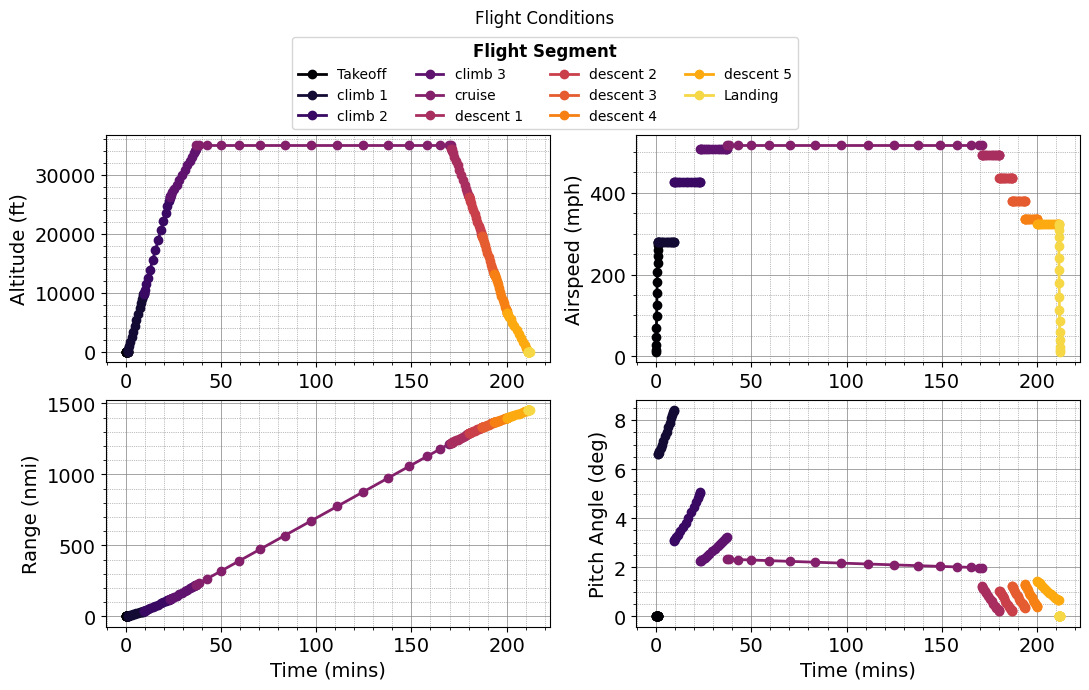

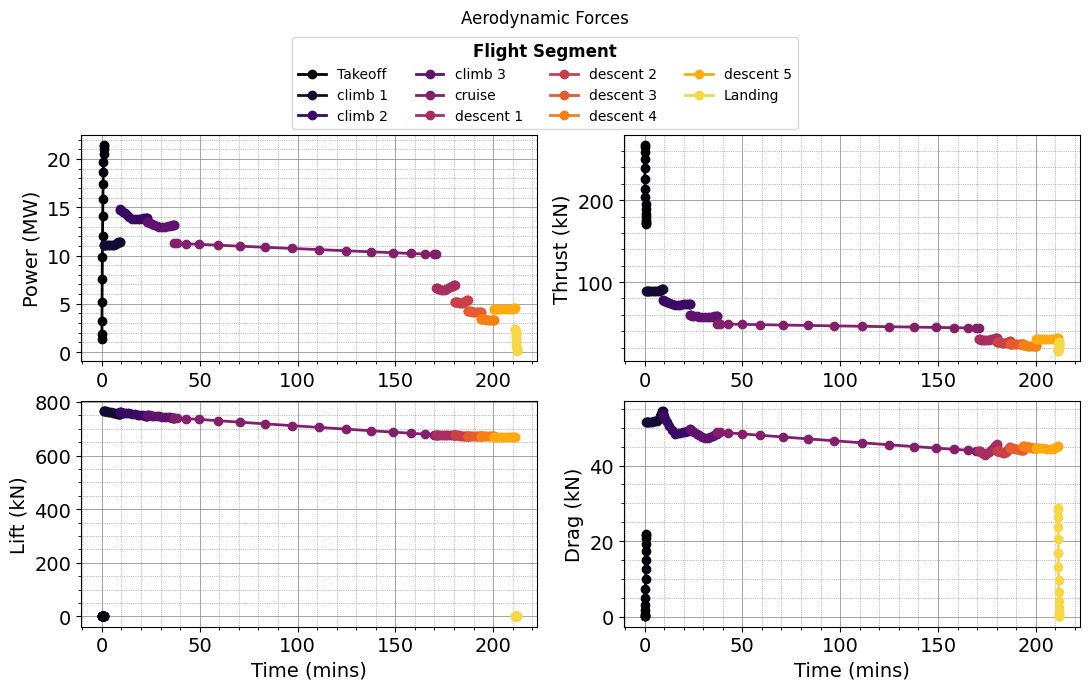

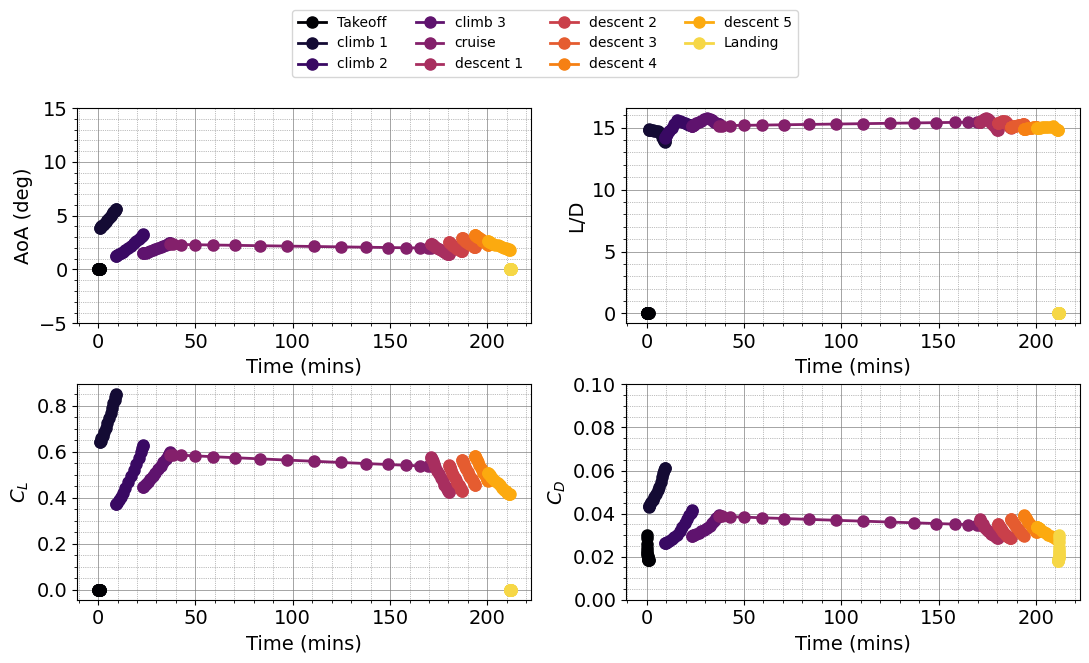

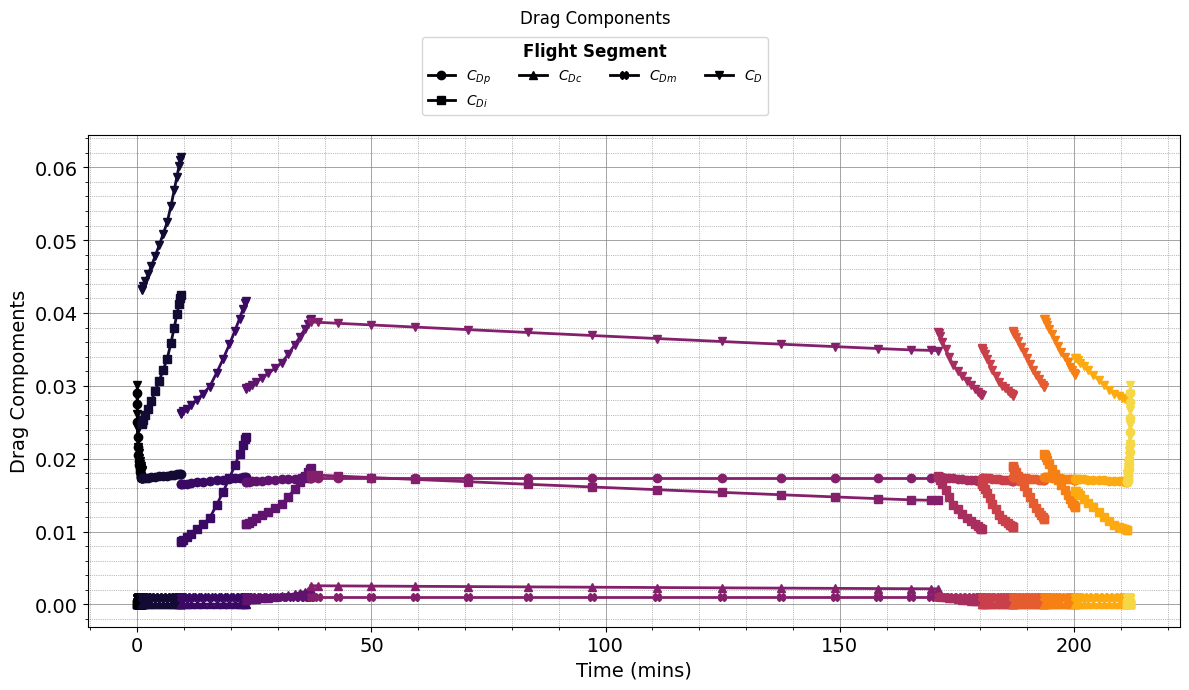

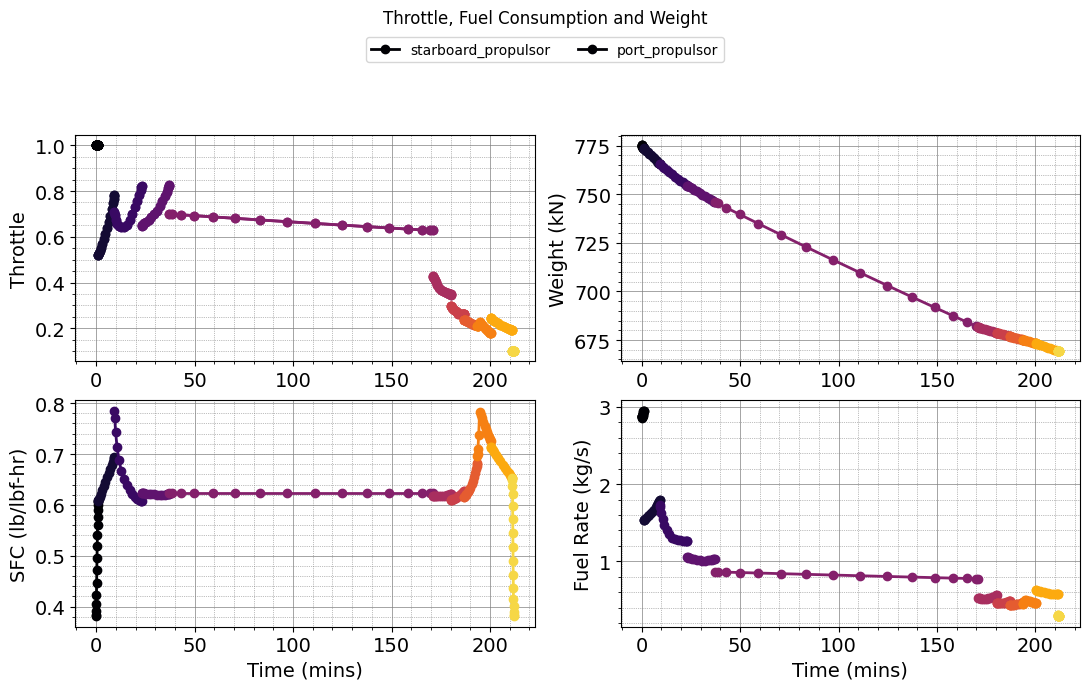

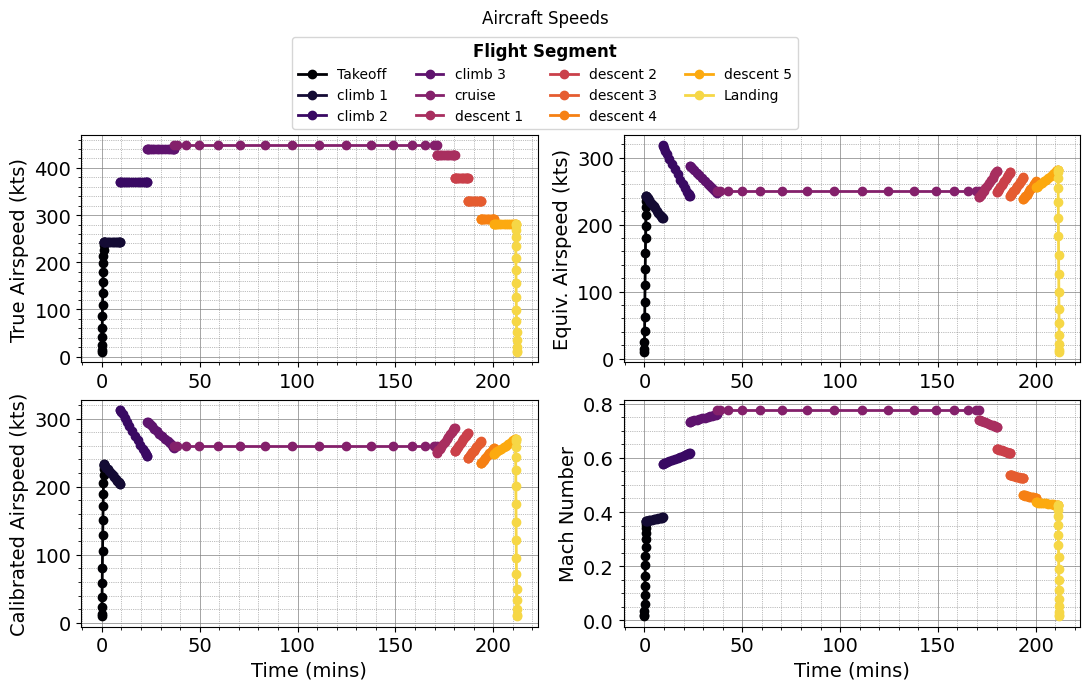

In [10]:

# Step 1 design a vehicle
vehicle  = vehicle_setup()    

# Step 2 create aircraft configuration based on vehicle 
configs  = configs_setup(vehicle)

# Step 3 set up analysis
analyses = analyses_setup(configs)

# Step 4 set up a flight mission
mission = mission_setup(analyses)
missions = missions_setup(mission) 

# Step 5 execute flight profile
results = missions.base_mission.evaluate()  

# Step 6 plot results 
plot_mission(results)
plt.show()


